In [ ]:
#  https://archive.ics.uci.edu/ml/datasets/CNNpred%3A+CNN-based+stock+market+prediction+using+a+diverse+set+of+variables

'''
Looking at the Nasdaq data in the CNN-pred stock data. 

Ran an ARIMA autoregression on the Nasdaq close price data, and graphed the results. 

Then tried a statespace ARIMA model, did a grid search for the best parameters, foudn the model with the lowest AIC, then 
used that. 

'''


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import datetime 

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
filename_prefix = 'C://Users/Tim/Downloads/CNNpred'

djiDF = pd.read_csv(filename_prefix + '/Processed_DJI.csv', index_col = 'Date', parse_dates = True)
nasdaqDF = pd.read_csv(filename_prefix + '/Processed_NASDAQ.csv', index_col = 'Date', parse_dates = True)
nyseDF = pd.read_csv(filename_prefix + '/Processed_NYSE.csv', index_col = 'Date', parse_dates = True)
russellDF = pd.read_csv(filename_prefix + '/Processed_RUSSELL.csv', index_col = 'Date', parse_dates = True)
spDF = pd.read_csv(filename_prefix + '/Processed_S&P.csv', index_col = 'Date', parse_dates = True)

In [3]:
n = 19 # not TE1, TE2, TE3, DE1, DE2, DE4, DE5, DE6

not_null_cols = nasdaqDF.columns[:19]

dataDF = nasdaqDF.dropna(subset = not_null_cols).fillna(nasdaqDF.mean()) #.fillna(-100)

In [4]:
df_log = dataDF['Close']

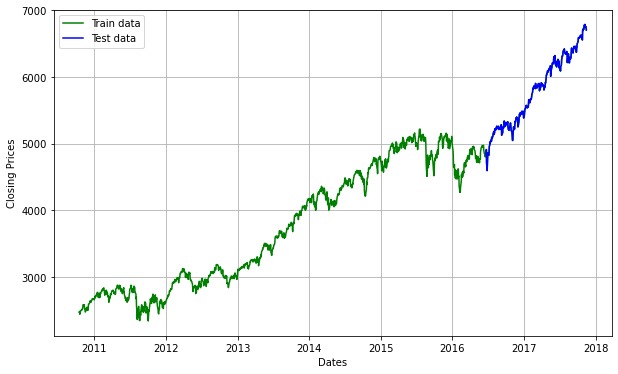

In [5]:
part = 0.80
train_data, test_data = df_log[3:int(len(df_log)*part)], df_log[int(len(df_log)*part):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [6]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(3, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1424
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -7243.696
Method:                       css-mle   S.D. of innovations             39.170
Date:                Tue, 11 Aug 2020   AIC                          14499.393
Time:                        01:37:58   BIC                          14530.960
Sample:                             1   HQIC                         14511.183
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.6531      0.871      1.898      0.058      -0.054       3.360
ar.L1.D.Close     0.7680      0.196      3.910      0.000       0.383       1.153
ar.L2.D.Close     0.0004      0.033     

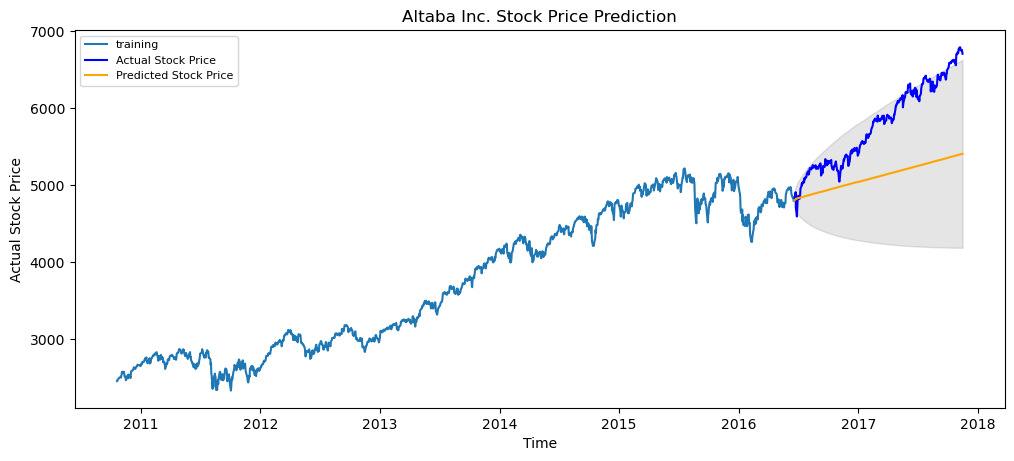

In [7]:
# Forecast
fc, se, conf = fitted.forecast(len(test_data.index), alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Altaba Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [10]:
import warnings
import statsmodels.api as sm

aic_full = pd.DataFrame(np.zeros((6,6), dtype=float))
aic_miss = pd.DataFrame(np.zeros((6,6), dtype=float))

warnings.simplefilter('ignore')

# Iterate over all ARMA(p,q) models with p,q in [0,6]
for p in range(6):
    for q in range(6):
        if p == 0 and q == 0:
            continue

        # Estimate the model with no missing datapoints
        mod = sm.tsa.statespace.SARIMAX(train_data, order=(p,0,q), enforce_invertibility=False)
        try:
            res = mod.fit(disp=False)
            aic_full.iloc[p,q] = res.aic
        except:
            aic_full.iloc[p,q] = np.nan

In [11]:
aic_full

,0,1,2,3,4,5
0,0.000000,26519.783111,23859.885995,22331.732003,21423.389424,25433.530293
1,14521.291267,14522.874476,14524.669863,14522.938498,14524.323315,14523.330918
2,14522.869122,14525.031677,14526.824352,14528.577847,14526.675487,14528.258720
3,14524.722352,14526.851336,14525.578587,14530.272336,14532.149095,14529.990553
4,14525.853040,14529.495730,14531.685825,14516.456252,14519.419562,14532.952864
5,14737.099294,14526.532803,14528.849909,14520.392459,14528.146366,14535.855628


In [12]:
mod = sm.tsa.statespace.SARIMAX(train_data, order=(4,0,3), enforce_invertibility=False)

fitted = mod.fit(disp=-1)  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1425
Model:               SARIMAX(4, 0, 3)   Log Likelihood               -7250.228
Date:                Tue, 11 Aug 2020   AIC                          14516.456
Time:                        01:46:33   BIC                          14558.552
Sample:                             0   HQIC                         14532.179
                               - 1425                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6532      0.067     -9.782      0.000      -0.784      -0.522
ar.L2          0.0351      0.030      1.182      0.237      -0.023       0.093
ar.L3          0.6578      0.027     24.300      0.0

In [19]:
# Forecast
fc, se, conf = fitted.forecast(steps = 1)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Altaba Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

ValueError: not enough values to unpack (expected 3, got 1)